In [1]:
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np

### Initial conditions

In [2]:
skills = {1:{'p':0.1, 'v':240}, 
          2:{'p':0.2, 'v':120}, 
          3:{'p':0.3, 'v':80}, 
          4:{'p':0.4, 'v':60}, 
          5:{'p':0.5, 'v':48},
          6:{'p':0.6, 'v':40}}

In [3]:
expected_unskilled = 1
for key in skills:
    expected_unskilled *= (1-skills[key]['p'])
print("expected number of unskilled persons in a sample of 100 is", 100*expected_unskilled)

expected number of unskilled persons in a sample of 100 is 6.048000000000001


### Simulating network

Note: money is in $ 1000

In [4]:
def initial_wealth_distribution():
    return max(0,np.random.randn()*10+10)
def initial_payroll():
    #mean = $50,000/12 ≈ $4,150, sd = $20,000/12 ≈ $1,650
    return min(max(0,np.random.randn()*1.65+4.15), 17)
cost_of_living = 0.85

In [20]:
def initiate(num_people, num_companies):
    G = nx.Graph()
    n = num_people + num_companies
    G.add_nodes_from(np.arange(1,n+1))
    people_index = np.arange(0,num_people)
    company_index = np.arange(num_people,n)
    P = [{"money": initial_wealth_distribution(), 
          "skills":[skill for skill in skills 
                    if np.random.random() < skills[skill]['p']],
          "jobs": [],
          "salary": 0,
          "job_offers":{}} for i in range(num_people)]
    C = [{"utility": 100000, "payroll": initial_payroll(), "employees":[], "applications":[]} 
         for i in range(num_companies)]
    return G, P, C, people_index, company_index

In [21]:
def marginal_contribution_of_employee(c, v):
    return np.sqrt((C[c]["utility"])**2+v) - C[c]["utility"]

In [22]:
def hire(c, v):
    if marginal_contribution_of_employee(c, v) > 0: #task: decide the criteria
        return 1
    return 0

In [23]:
def leisure_vs_consumption():
    leisure = np.random.random()
    consumption = 1 - leisure
    return leisure, consumption

In [156]:
def evolve(G, tax_rate=0.1):
    
    values = np.zeros(num_people)
    
    for person in people_index:
        values[person] = sum([skills[i]['v'] for i in P[person]['skills']])
        leisure, consumption = leisure_vs_consumption()
        money = P[person]["money"]
        salary = P[person]["salary"]
        
        #the person looks for a job
        if P[person]['jobs'] != [] or money + salary <= cost_of_living:
            for company in company_index:
                company = company - num_people
                #if the person needs a job to pay the costs of living, then he must apply for it
                if money - cost_of_living <= 0:
                    C[company]['applications'].append(person)
                #person considers the tax rate while weighing tradeoffs
                elif np.log(np.exp(money) + C[company]["payroll"] * values[person]/100)*(1-tax_rate) > 0.1: #task: decide the criteria
                    C[company]['applications'].append(person)
                    
        elif money > cost_of_living:
            if leisure > consumption:
                P[person]['jobs'] = []
                P[person]['salary'] = 0
        
    #companies consider applicants
    for company in company_index:
        company_arg = company - num_people
        for applicant in C[company_arg]["applications"]:
            if hire(company_arg, values[applicant]):
                P[applicant]['job_offers'][company] = C[company_arg]["payroll"] * values[applicant]/100 #salaries do not mention taxes
                
        C[company_arg]["applications"] = []
     
    #person accepts of rejects job offers
    for person in people_index:
        job_offers = P[person]['job_offers']
        best_offer  = 0
        best_provider = None
        
        if job_offers != {}:
            for offer in job_offers:
                if job_offers[offer] > best_offer:
                    best_offer = job_offers[offer]
                    best_provider = offer
                
            P[person]['jobs'] = [best_provider] #if a person already has a job he has to drop it
            P[person]['salary'] = best_offer
        
            edge = (best_provider, person)
            G.add_edge(*edge)
        
            P[person]['job_offers'] = {}
        
        P[person]['money'] += P[person]['salary']*(1-tax_rate)
        #task: subtract money from companies after incorporating profit mechanism
        
        #subtract cost of living
        P[person]["money"] -= cost_of_living
    
    return G

In [157]:
num_people = 100
num_companies = 10

G, P, C, people_index, company_index = initiate(num_people, num_companies)

In [174]:
G = evolve(G, tax_rate=1)

In [175]:
print("Nodes of graph: ")
print(G.nodes())
print("Edges of graph: ")
print(G.edges())

Nodes of graph: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 0]
Edges of graph: 
[(1, 104), (5, 104), (6, 104), (9, 104), (12, 104), (13, 104), (15, 104), (19, 104), (22, 104), (26, 104), (28, 104), (32, 104), (33, 104), (34, 104), (40, 104), (45, 104), (47, 104), (51, 104), (55, 104), (56, 104), (60, 104), (63, 104), (66, 104), (68, 104), (69, 104), (72, 104), (73, 104), (75, 104), (76, 104), (77, 104), (79, 104), (88, 104), (90, 104), (94, 104), (97, 104), (104, 0)]


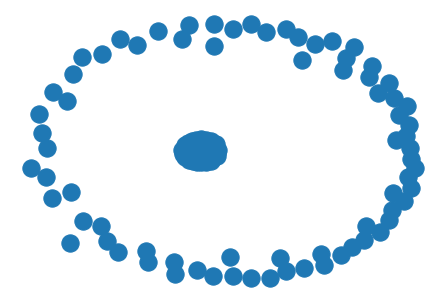

In [176]:
nx.draw(G)
plt.show()

In [177]:
P

[{'money': -6.799999999999999,
  'skills': [2, 3, 5, 6],
  'jobs': [104],
  'salary': 20.26547990673457,
  'job_offers': {}},
 {'money': -6.799999999999999,
  'skills': [2, 3, 4, 5, 6],
  'jobs': [104],
  'salary': 24.48745488730427,
  'job_offers': {}},
 {'money': 7.003776324107985,
  'skills': [4, 6],
  'jobs': [],
  'salary': 0,
  'job_offers': {}},
 {'money': 5.073458715709741,
  'skills': [5, 6],
  'jobs': [],
  'salary': 0,
  'job_offers': {}},
 {'money': 7.064617227724916,
  'skills': [4, 5],
  'jobs': [],
  'salary': 0,
  'job_offers': {}},
 {'money': -3.650013875014959,
  'skills': [5, 6],
  'jobs': [104],
  'salary': 6.192229971502229,
  'job_offers': {}},
 {'money': -5.196704834429666,
  'skills': [3, 5, 6],
  'jobs': [104],
  'salary': 11.821529945595167,
  'job_offers': {}},
 {'money': 0.19899835329206683,
  'skills': [3, 5, 6],
  'jobs': [],
  'salary': 0,
  'job_offers': {}},
 {'money': 4.517041097181679,
  'skills': [5, 6],
  'jobs': [],
  'salary': 0,
  'job_offers': {